In [1]:
# Imports
from lib.utils import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn.functional import relu,one_hot
from tqdm import tqdm
device = 'cuda'
torch.cuda.empty_cache()

/home/andrew/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X,y = load_raw_list([20,21,22,23,24,25,26])

In [3]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,shuffle=True,stratify=y,random_state=0)

In [4]:
y_train_one_hot = one_hot(y_train,num_classes=3).reshape(-1,3).float()
y_test_one_hot = one_hot(y_test,num_classes=3).reshape(-1,3).float()
X_train = X_train.reshape(-1,1,5000)
y_train_one_hot = y_train_one_hot
X_test = X_test.reshape(-1,1,5000)
y_test_one_hot = y_test_one_hot
from torch.utils.data import TensorDataset
training_data = TensorDataset(X_train,y_train_one_hot)
testing_data = TensorDataset(X_test,y_test_one_hot)
from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size=128, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=128, shuffle=True)

In [5]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.c1 = nn.Conv1d(1, 16, kernel_size=100, stride=10, padding=1)
        self.c2 = nn.Conv1d(16, 8, kernel_size=100, stride=10, padding=1)
        self.fc1 = nn.Linear(56, 3)

    def forward(self,x):
        x = self.c1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool1d(x, kernel_size=2)
        x = self.c2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool1d(x, kernel_size=2)
        x = x.view(-1, 56)
        x = self.fc1(x)
        
        return x
model = MLP().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [6]:
model(X_train[0].reshape(-1,1,5000).cuda()).shape

torch.Size([1, 3])

In [18]:
train_losses = []
test_losses = []

In [19]:
for epoch in range(50):
    training_loss = 0
    model.train()
    for (X,y) in train_dataloader:
        X,y = X.to(device), y.to(device)
        logits = model(X)
        loss = criterion(logits,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    if(epoch%10 == 0):
        train_losses.append(training_loss/len(train_dataloader))
        model.eval()
        testing_loss = 0
        for (X,y) in test_dataloader:
            X,y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits,y)
            testing_loss += loss.item()
        test_losses.append(testing_loss/len(test_dataloader))
        print(f'Epoch {epoch} Train: {training_loss/len(train_dataloader)} Test: {testing_loss/len(test_dataloader)}')

Epoch 0 Train: 0.2916802725700474
Epoch 0 Train: 0.2916802725700474 Test: 0.3189436145518955
Epoch 1 Train: 0.29125673816632974
Epoch 2 Train: 0.29215345519875724
Epoch 3 Train: 0.2973155232649001
Epoch 4 Train: 0.29388014408488755
Epoch 5 Train: 0.29114908997028593
Epoch 6 Train: 0.2955342994007484
Epoch 7 Train: 0.2938920826744781
Epoch 8 Train: 0.29440880566835403
Epoch 9 Train: 0.2917356070071932
Epoch 10 Train: 0.29212938410737527
Epoch 10 Train: 0.29212938410737527 Test: 0.31473382068307776
Epoch 11 Train: 0.29212006780678634
Epoch 12 Train: 0.2941511530409414
Epoch 13 Train: 0.2907316051620655
Epoch 14 Train: 0.2932422461096572
Epoch 15 Train: 0.29594724136527883
Epoch 16 Train: 0.28891478784421765
Epoch 17 Train: 0.29461204879498354
Epoch 18 Train: 0.2892317887415331
Epoch 19 Train: 0.29439902691929426
Epoch 20 Train: 0.2925606333310642
Epoch 20 Train: 0.2925606333310642 Test: 0.31832611200056576
Epoch 21 Train: 0.2941213519800277
Epoch 22 Train: 0.292583568465142
Epoch 23 Trai

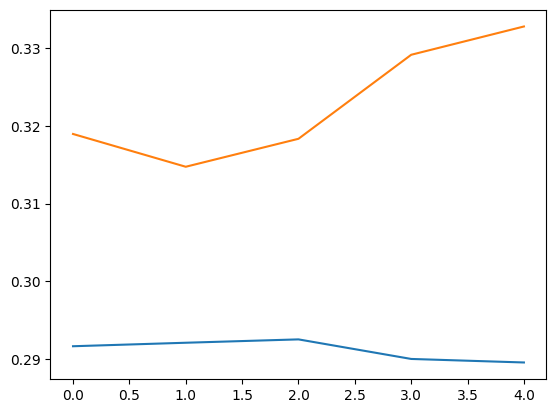

In [20]:
plt.plot(train_losses,label='train')
plt.plot(test_losses,label='validation')
plt.savefig('loss.jpg',dpi=200)

In [21]:
import seaborn as sns
sm = nn.Softmax(dim=1)
y_pred_train = []
y_pred_test = []
for sample in X_train:
    y_pred_train.append(sm(model(sample.cuda())).argmax(axis=1).item())
for sample in X_test:
    y_pred_test.append(sm(model(sample.cuda())).argmax(axis=1).item())

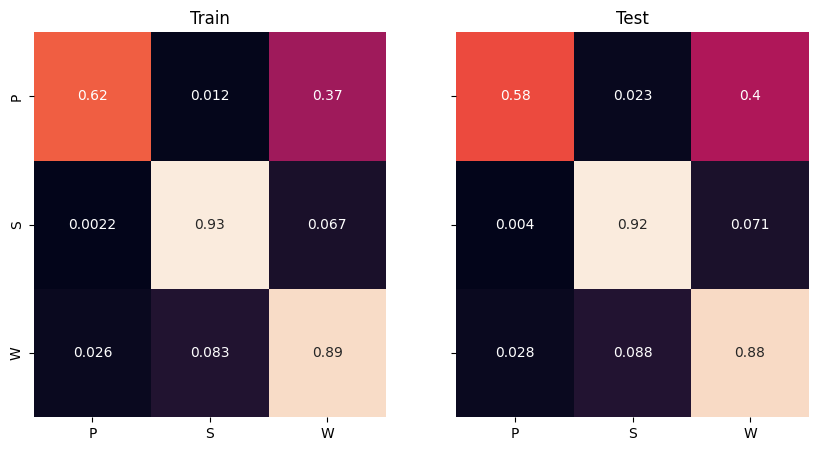

In [22]:
fig,axes = plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(10,5),dpi=100)
sns.heatmap(confusion_matrix(y_train,y_pred_train,normalize='true'),ax=axes[0],annot=True,cbar=False)
sns.heatmap(confusion_matrix(y_test,y_pred_test,normalize='true'),ax=axes[1],annot=True,cbar=False)
axes[0].set_title('Train')
axes[0].set_yticklabels(['P','S','W'])
axes[0].set_xticklabels(['P','S','W'])
axes[1].set_title('Test')
axes[1].set_xticklabels(['P','S','W'])
plt.savefig('cm.jpg',dpi=200)

In [ ]:
fig,axes = plt.subplots(nrows=len(model.c1.weight),ncols=1,figsize=(32,18))
for i in range(len(model.c1.weight)):
    axes[i].plot(model.c1.weight[i].squeeze().detach().cpu())
plt.savefig('kernels.jpg',dpi=500)

In [ ]:
torch.save(obj=model,f='model.pt')